In [2]:
DATASET = 'ENZYMES'
if 'first_run' not in globals():
    !pip install torch torch-geometric
    first_run = False
else:
    pass


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.8 MB/s eta 0:00:0000:0100:01


In [3]:
import hashlib
import numpy as np
import torch
from torch_geometric.transforms import BaseTransform
from torch_geometric.utils import to_scipy_sparse_matrix
from torch_geometric.data import Data
from torch_geometric.io import fs, read_txt_array
import torch_geometric.transforms as T
# from torch_geometric.datasets import TUDataset
from torch_geometric.data import Data, InMemoryDataset
import math
from typing import Callable, List, Optional, Tuple, Dict
from torch import Tensor
import os
import requests
from torch_geometric.utils import coalesce, cumsum, one_hot, remove_self_loops

In [4]:
# class MyTransform(BaseTransform):
#     def __init__(self, set_ids = False, indices = None, set_initial_features=False, embedding=None, cos_sim=None, z_score=None):
#         super(MyTransform, self).__init__()
#         self.current_id = 0  # Initialize a counter for unique IDs
#         self.set_initial_features = set_initial_features
#         self.embedding = embedding  # Assume this is a function if not None
#         self.cos_sim = cos_sim      # Assume this is a dictionary or list if not None
#         self.z_score = z_score      # Assume this is a dictionary or list if not None
#         self.indices = indices
#         if set_ids:
#             self.assign_ids()

#     def assign_ids(self):
#         # Create an ID tensor for all data points
#         id_tensor = torch.arange(self.indices)
#         for i, data in enumerate(self):
#             data.id = id_tensor[i]

#     def __call__(self, data: Data) -> Data:
#         # Assign a unique ID and increment the counter
#         if self.set_initial_features:
#             data.id = self.current_id
#             self.current_id += 1
#             data.num_edges = data.edge_index.size(1)  # Number of edges
#             data.adj_mat = self.to_numpy_adj(data)  # Convert edge index to adjacency matrix

#         if self.embedding:
#             data.embedding = self.embedding[data.id] # Assume embedding function takes Data and modifies it

#         if self.cos_sim is not None:
#             data.cos_sim = self.cos_sim[data.id]  # Fetch cosine similarity based on ID

#         if self.z_score is not None:
#             data.z_score = self.z_score[data.id]  # Fetch z-score based on ID

#         return data

#     def to_numpy_adj(self, data):
#         # Creates an adjacency matrix from edge_index
#         adj_mat = np.zeros((data.num_nodes, data.num_nodes))
#         edge_index = data.edge_index.numpy()
#         adj_mat[edge_index[0], edge_index[1]] = 1
#         return adj_mat

In [5]:
class IDAddingDataset:
    def __init__(self, dataset, attr_func):
        self.dataset = dataset
        self.attr_func = attr_func
        self.indices = np.arange(0, len(dataset.indices()))
    
    def __getitem__(self, idx):
        data = self.dataset[idx].clone()  # Clone the data to avoid modifying the original dataset
        data.id = self.indices[idx]
        data.num_edges = self.dataset[idx].edge_index.size(1)
        data.adj_mat = to_scipy_sparse_matrix(self.dataset[idx].edge_index, num_nodes=self.dataset[idx].num_nodes).toarray().astype(int)
        return data
    
    def __len__(self):
        return len(self.dataset)


In [6]:
class EmbeddingAddingDataset:
    def __init__(self, dataset, embedding_dict):
        self.dataset = dataset
        self.embedding_dict = embedding_dict
    
    def __getitem__(self, idx):
        data = self.dataset[idx].clone()  # Clone the data to avoid modifying the original dataset
        data.embedding = self.embedding_dict[self.dataset[idx].id]
        return data
    
    def __len__(self):
        return len(self.dataset)

In [7]:
class FinalAddingDataset:
    def __init__(self, Embedding_dataset, cos_sims, all_z_scores):
        self.dataset = Embedding_dataset
        self.cos_sims = cos_sims
        self.all_z_scores = all_z_scores
        
    
    def __getitem__(self, idx):
        data = self.dataset[idx].clone()  # Clone the data to avoid modifying the original dataset
        data.cos_sim = self.cos_sims[self.dataset[idx].id]
        data.z_score = self.all_z_scores[self.dataset[idx].id]
        return data
    
    def __len__(self):
        return len(self.dataset)

In [8]:
def stable_hash(value):
    return hashlib.md5(str(value).encode()).hexdigest()
def get_WL_embedding(data, n_iter):
    graph = data.adj_mat
    graph_hash_dict = {}
    labels = [np.sum(graph[x]) for x in range(len(graph))]  # Initialize labels based on node degrees
    for _ in range(n_iter):
        neighbor_labels = [sorted([labels[j] for j in range(len(graph)) if graph[i, j] == 1]) for i in range(len(graph))]
        hashes = np.array([stable_hash((labels[i], tuple(neighbor_labels[i]))) for i in range(len(graph))])
        
        for unique_hash in set(hashes):
            graph_hash_dict[unique_hash] = np.sum(hashes == unique_hash)

        labels = hashes.tolist()

    return graph_hash_dict

In [9]:
import hashlib
import numpy as np

def stable_hash(value):
    return hashlib.md5(str(value).encode()).hexdigest()

def get_WL_embedding(data, n_iter):
    graph = data.adj_mat
    graph_hash_dict = {}
    no_hash_dict = {}
    labels = [np.sum(graph[x]) for x in range(len(graph))]  # Initialize labels based on node degrees
    unlabels = [x for x in labels]

    for _ in range(n_iter):
        neighbor_labels = [sorted([labels[j] for j in range(len(graph)) if graph[i, j] == 1]) for i in range(len(graph))]
        neighbor_unlabels = [sorted([unlabels[j] for j in range(len(graph)) if graph[i, j] == 1]) for i in range(len(graph))]
        
        hashes = np.array([stable_hash((labels[i], tuple(neighbor_labels[i]))) for i in range(len(graph))])
        unhashes = [(unlabels[i], tuple(neighbor_unlabels[i])) for i in range(len(graph))]
        
        for unique_hash in set(hashes):
            graph_hash_dict[unique_hash] = np.sum(hashes == unique_hash)
        
        for unique_unlabel in set(unhashes):
            no_hash_dict[unique_unlabel] = sum(unique_unlabel == label for label in unhashes)
        
        labels = hashes.tolist()
        unlabels = unhashes

    return graph_hash_dict, no_hash_dict

# Example usage:
# hashes, unhashes = get_WL_embedding(ID_dataset[1], 3)


In [53]:
def get_mean_vectors(dataset):
    all_hashes = set()
    all_classes = set()
    for graph in dataset:
        all_hashes.update(graph.embedding[0].keys())
        all_classes.add(graph.y.item())
    all_classes.add('all')

    vector_sum_dict = {_cls: {h: 0 for h in all_hashes} for _cls in all_classes}
    category_sum_dict = {_cls: 0 for _cls in all_classes}
    mean_vector_dict = {_cls: {h: 0 for h in all_hashes} for _cls in all_classes}
    
    
    for graph in dataset:
        for _hash, count in graph.embedding[0].items():
            vector_sum_dict[graph.y.item()][_hash] += count
            category_sum_dict[graph.y.item()] += 1
            vector_sum_dict['all'][_hash] += count
            category_sum_dict['all'] += 1
    for _cls, hash_counts in vector_sum_dict.items():
        for _hash, count in hash_counts.items():
            mean_vector_dict[_cls][_hash] = count/category_sum_dict[_cls]
    return all_hashes, all_classes, mean_vector_dict

def get_cos_sim(dataset, all_hashes, all_classes, mean_vectors):
    cos_sims, norm_dict = {}, {}
    graph_norm = math.sqrt(sum(count**2 for count in graph.embedding[0].values()))
    for _class in all_classes:
        norm_dict[_class] = math.sqrt(sum(count**2 for count in mean_vectors[_class].values()))
    all_numerator = sum(count * mean_vectors['all'][_hash] for _hash, count in graph.embedding[0].items())
    all_denom = norm_dict['all'] * graph_norm
    cos_sims['all'] = all_numerator / all_denom

    class_numerator = sum(count * mean_vectors[graph.y.item()][_hash] for _hash, count in graph.embedding[0].items())
    class_denom = norm_dict[graph.y.item()] * graph_norm
    cos_sims['class'] = class_numerator / class_denom
    
    return cos_sims

def calc_z_scores(graph, cos_sims, class_cos_sims):
    # Ensure data types are numpy arrays for statistical computation
    all_cos_sims = np.array(class_cos_sims['all'])
    cat_cos_sims = np.array(class_cos_sims[graph.y.item()])
    
    # Calculate means and standard deviations for 'all' and specific 'class'
    all_mean = np.mean(all_cos_sims)
    cat_mean = np.mean(cat_cos_sims)
    all_std_dev = np.std(all_cos_sims)
    class_std_dev = np.std(cat_cos_sims)
    
    # Compute z-scores using the standard formula, include flooring to nearest 0.5 if needed
    z_scores = {
        'all': (cos_sims[graph.id]['all']) / all_std_dev,
        'class': (cos_sims[graph.id]['class']) / class_std_dev
    }
    
    return z_scores

In [11]:
# from torch_geometric.io.tu import read_tu_data
# data, slices, sizes = read_tu_data('/kaggle/working/', 'ENZYMES')

In [12]:
# import os.path as osp
# from typing import Callable, List, Optional

# from torch_geometric.data import Data, InMemoryDataset
# from torch_geometric.io import fs#, read_tu_data

# def read_file(
#     folder: str,
#     prefix: str,
#     name: str,
#     dtype: Optional[torch.dtype] = None,
# ) -> Tensor:
#     path = osp.join(folder, f'{prefix}_{name}.txt')
#     return read_txt_array(path, sep=',', dtype=dtype)
# def cat(seq: List[Optional[Tensor]]) -> Optional[Tensor]:
#     values = [v for v in seq if v is not None]
#     values = [v for v in values if v.numel() > 0]
#     values = [v.unsqueeze(-1) if v.dim() == 1 else v for v in values]
#     return torch.cat(values, dim=-1) if len(values) > 0 else None
# def split(data: Data, batch: Tensor) -> Tuple[Data, Dict[str, Tensor]]:
#     node_slice = cumsum(torch.from_numpy(np.bincount(batch)))

#     assert data.edge_index is not None
#     row, _ = data.edge_index
#     edge_slice = cumsum(torch.from_numpy(np.bincount(batch[row])))

#     # Edge indices should start at zero for every graph.
#     data.edge_index -= node_slice[batch[row]].unsqueeze(0)

#     slices = {'edge_index': edge_slice}
#     if data.x is not None:
#         slices['x'] = node_slice
#     else:
#         # Imitate `collate` functionality:
#         data._num_nodes = torch.bincount(batch).tolist()
#         data.num_nodes = batch.numel()
#     if data.edge_attr is not None:
#         slices['edge_attr'] = edge_slice
#     if data.y is not None:
#         assert isinstance(data.y, Tensor)
#         if data.y.size(0) == batch.size(0):
#             slices['y'] = node_slice
#         else:
#             slices['y'] = torch.arange(0, int(batch[-1]) + 2, dtype=torch.long)

#     return data, slices
# def read_tu_data(
#     folder: str,
#     prefix: str,
# ) -> Tuple[Data, Dict[str, Tensor], Dict[str, int]]:
#     files = fs.glob(osp.join(folder, f'{prefix}_*.txt'))
#     names = [osp.basename(f)[len(prefix) + 1:-4] for f in files]

#     edge_index = read_file(folder, prefix, 'A', torch.long).t() - 1
#     batch = read_file(folder, prefix, 'graph_indicator', torch.long) - 1

#     node_attribute = torch.empty((batch.size(0), 0))
#     if 'node_attributes' in names:
#         node_attribute = read_file(folder, prefix, 'node_attributes')
#         if node_attribute.dim() == 1:
#             node_attribute = node_attribute.unsqueeze(-1)

#     node_label = torch.empty((batch.size(0), 0))
#     if 'node_labels' in names:
#         node_label = read_file(folder, prefix, 'node_labels', torch.long)
#         if node_label.dim() == 1:
#             node_label = node_label.unsqueeze(-1)
#         node_label = node_label - node_label.min(dim=0)[0]
#         node_labels = list(node_label.unbind(dim=-1))
#         node_labels = [one_hot(x) for x in node_labels]
#         if len(node_labels) == 1:
#             node_label = node_labels[0]
#         else:
#             node_label = torch.cat(node_labels, dim=-1)

#     edge_attribute = torch.empty((edge_index.size(1), 0))
#     if 'edge_attributes' in names:
#         edge_attribute = read_file(folder, prefix, 'edge_attributes')
#         if edge_attribute.dim() == 1:
#             edge_attribute = edge_attribute.unsqueeze(-1)

#     edge_label = torch.empty((edge_index.size(1), 0))
#     if 'edge_labels' in names:
#         edge_label = read_file(folder, prefix, 'edge_labels', torch.long)
#         if edge_label.dim() == 1:
#             edge_label = edge_label.unsqueeze(-1)
#         edge_label = edge_label - edge_label.min(dim=0)[0]
#         edge_labels = list(edge_label.unbind(dim=-1))
#         edge_labels = [one_hot(e) for e in edge_labels]
#         if len(edge_labels) == 1:
#             edge_label = edge_labels[0]
#         else:
#             edge_label = torch.cat(edge_labels, dim=-1)

#     x = cat([node_attribute, node_label])
#     edge_attr = cat([edge_attribute, edge_label])

#     y = None
#     if 'graph_attributes' in names:  # Regression problem.
#         y = read_file(folder, prefix, 'graph_attributes')
#     elif 'graph_labels' in names:  # Classification problem.
#         y = read_file(folder, prefix, 'graph_labels', torch.long)
#         _, y = y.unique(sorted=True, return_inverse=True)

#     num_nodes = int(edge_index.max()) + 1 if x is None else x.size(0)
#     edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
#     edge_index, edge_attr = coalesce(edge_index, edge_attr, num_nodes)
#     cos_sim = torch.tensor([-1.0])
#     z_score = torch.tensor([-1.0])

    
    
    
#     data = Data(
#         x=x,
#         edge_index=edge_index,
#         edge_attr=edge_attr,
#         y=y,
#         cos_sim=torch.tensor([-1.0]),  # Custom attribute
#         z_score=torch.tensor([-1.0])   # Custom attribute
#     )
#     data, slices = split(data, batch)

#     sizes = {
#         'num_node_attributes': node_attribute.size(-1),
#         'num_node_labels': node_label.size(-1),
#         'num_edge_attributes': edge_attribute.size(-1),
#         'num_edge_labels': edge_label.size(-1),
#     }

#     return data, slices, sizes

# class MyTUDataset(InMemoryDataset):
#     r"""A variety of graph kernel benchmark datasets, *.e.g.*,
#     :obj:`"IMDB-BINARY"`, :obj:`"REDDIT-BINARY"` or :obj:`"PROTEINS"`,
#     collected from the `TU Dortmund University
#     <https://chrsmrrs.github.io/datasets>`_.
#     In addition, this dataset wrapper provides `cleaned dataset versions
#     <https://github.com/nd7141/graph_datasets>`_ as motivated by the
#     `"Understanding Isomorphism Bias in Graph Data Sets"
#     <https://arxiv.org/abs/1910.12091>`_ paper, containing only non-isomorphic
#     graphs.

#     .. note::
#         Some datasets may not come with any node labels.
#         You can then either make use of the argument :obj:`use_node_attr`
#         to load additional continuous node attributes (if present) or provide
#         synthetic node features using transforms such as
#         :class:`torch_geometric.transforms.Constant` or
#         :class:`torch_geometric.transforms.OneHotDegree`.

#     Args:
#         root (str): Root directory where the dataset should be saved.
#         name (str): The `name
#             <https://chrsmrrs.github.io/datasets/docs/datasets/>`_ of the
#             dataset.
#         transform (callable, optional): A function/transform that takes in an
#             :obj:`torch_geometric.data.Data` object and returns a transformed
#             version. The data object will be transformed before every access.
#             (default: :obj:`None`)
#         pre_transform (callable, optional): A function/transform that takes in
#             an :obj:`torch_geometric.data.Data` object and returns a
#             transformed version. The data object will be transformed before
#             being saved to disk. (default: :obj:`None`)
#         pre_filter (callable, optional): A function that takes in an
#             :obj:`torch_geometric.data.Data` object and returns a boolean
#             value, indicating whether the data object should be included in the
#             final dataset. (default: :obj:`None`)
#         force_reload (bool, optional): Whether to re-process the dataset.
#             (default: :obj:`False`)
#         use_node_attr (bool, optional): If :obj:`True`, the dataset will
#             contain additional continuous node attributes (if present).
#             (default: :obj:`False`)
#         use_edge_attr (bool, optional): If :obj:`True`, the dataset will
#             contain additional continuous edge attributes (if present).
#             (default: :obj:`False`)
#         cleaned (bool, optional): If :obj:`True`, the dataset will
#             contain only non-isomorphic graphs. (default: :obj:`False`)

#     **STATS:**

#     .. list-table::
#         :widths: 20 10 10 10 10 10
#         :header-rows: 1

#         * - Name
#           - #graphs
#           - #nodes
#           - #edges
#           - #features
#           - #classes
#         * - MUTAG
#           - 188
#           - ~17.9
#           - ~39.6
#           - 7
#           - 2
#         * - ENZYMES
#           - 600
#           - ~32.6
#           - ~124.3
#           - 3
#           - 6
#         * - PROTEINS
#           - 1,113
#           - ~39.1
#           - ~145.6
#           - 3
#           - 2
#         * - COLLAB
#           - 5,000
#           - ~74.5
#           - ~4914.4
#           - 0
#           - 3
#         * - IMDB-BINARY
#           - 1,000
#           - ~19.8
#           - ~193.1
#           - 0
#           - 2
#         * - REDDIT-BINARY
#           - 2,000
#           - ~429.6
#           - ~995.5
#           - 0
#           - 2
#         * - ...
#           -
#           -
#           -
#           -
#           -
#     """

#     url = 'https://www.chrsmrrs.com/graphkerneldatasets'
#     cleaned_url = ('https://raw.githubusercontent.com/nd7141/'
#                    'graph_datasets/master/datasets')

#     def __init__(
#         self,
#         root: str,
#         name: str,
#         transform: Optional[Callable] = None,
#         pre_transform: Optional[Callable] = None,
#         pre_filter: Optional[Callable] = None,
#         force_reload: bool = False,
#         use_node_attr: bool = False,
#         use_edge_attr: bool = False,
#         cleaned: bool = False,
#     ) -> None:
#         self.name = name
#         self.cleaned = cleaned
#         super().__init__(root, transform, pre_transform, pre_filter,
#                          force_reload=force_reload)

#         out = fs.torch_load(self.processed_paths[0])
#         if not isinstance(out, tuple) or len(out) < 3:
#             raise RuntimeError(
#                 "The 'data' object was created by an older version of PyG. "
#                 "If this error occurred while loading an already existing "
#                 "dataset, remove the 'processed/' directory in the dataset's "
#                 "root folder and try again.")
#         assert len(out) == 3 or len(out) == 4

#         if len(out) == 3:  # Backward compatibility.
#             data, self.slices, self.sizes = out
#             data_cls = Data
#         else:
#             data, self.slices, self.sizes, data_cls = out

#         if not isinstance(data, dict):  # Backward compatibility.
#             self.data = data
#         else:
#             self.data = data_cls.from_dict(data)

#         assert isinstance(self._data, Data)
#         if self._data.x is not None and not use_node_attr:
#             num_node_attributes = self.num_node_attributes
#             self._data.x = self._data.x[:, num_node_attributes:]
#         if self._data.edge_attr is not None and not use_edge_attr:
#             num_edge_attrs = self.num_edge_attributes
#             self._data.edge_attr = self._data.edge_attr[:, num_edge_attrs:]

#     @property
#     def raw_dir(self) -> str:
#         name = f'raw{"_cleaned" if self.cleaned else ""}'
#         return osp.join(self.root, self.name, name)

#     @property
#     def processed_dir(self) -> str:
#         name = f'processed{"_cleaned" if self.cleaned else ""}'
#         return osp.join(self.root, self.name, name)

#     @property
#     def num_node_labels(self) -> int:
#         return self.sizes['num_node_labels']

#     @property
#     def num_node_attributes(self) -> int:
#         return self.sizes['num_node_attributes']

#     @property
#     def num_edge_labels(self) -> int:
#         return self.sizes['num_edge_labels']

#     @property
#     def num_edge_attributes(self) -> int:
#         return self.sizes['num_edge_attributes']

#     @property
#     def raw_file_names(self) -> List[str]:
#         names = ['A', 'graph_indicator']
#         return [f'{self.name}_{name}.txt' for name in names]

#     @property
#     def processed_file_names(self) -> str:
#         return 'data.pt'
        
        
#         #Original Function
# #     def download(self) -> None:
# #         url = self.cleaned_url if self.cleaned else self.url
# #         fs.cp(f'{url}/{self.name}.zip', self.raw_dir, extract=True)
# #         for filename in fs.ls(osp.join(self.raw_dir, self.name)):
# #             fs.mv(filename, osp.join(self.raw_dir, osp.basename(filename)))
# #         fs.rm(osp.join(self.raw_dir, self.name))
        
#     #Dummy Function for already downloaded files
#     def download(self) -> None:
#         files = {
#     'ENZYMES_A.txt': 'https://raw.githubusercontent.com/snap-stanford/GraphRNN/master/dataset/ENZYMES/ENZYMES_A.txt',
#     'ENZYMES_graph_indicator.txt': 'https://raw.githubusercontent.com/snap-stanford/GraphRNN/master/dataset/ENZYMES/ENZYMES_graph_indicator.txt',
#     'ENZYMES_graph_labels.txt': 'https://raw.githubusercontent.com/snap-stanford/GraphRNN/master/dataset/ENZYMES/ENZYMES_graph_labels.txt',
#     'ENZYMES_node_attributes.txt': 'https://raw.githubusercontent.com/snap-stanford/GraphRNN/master/dataset/ENZYMES/ENZYMES_node_attributes.txt',
#     'ENZYMES_node_labels.txt': 'https://raw.githubusercontent.com/snap-stanford/GraphRNN/master/dataset/ENZYMES/ENZYMES_node_labels.txt'
#     }
#         dest_dir = '/kaggle/working/ENZYMES/raw/'

#         # Ensure destination directory exists
#         if not os.path.exists(dest_dir):
#             os.makedirs(dest_dir)

#         # Function to download and save a file
#         def download_and_save(url, destination):
#             # Make the HTTP GET request to the file URL
#             if os.dir.exists()
#             response = requests.get(url)
#             if response.status_code == 200:
#                 # Write the file contents in binary mode
#                 filename = os.path.join(destination, url.split('/')[-1])
#                 with open(filename, 'wb') as file:
#                     file.write(response.content)
#                 print(f"File saved as {filename}")
#             else:
#                 print(f"Failed to download {url}")

#         # Download and save each file
#         for file_url in files.values():
#             download_and_save(file_url, dest_dir)

#     def process(self) -> None:
#         self.data, self.slices, sizes = read_tu_data(self.raw_dir, self.name)
#         print(self.data.cos_sim)
#         if self.pre_filter is not None or self.pre_transform is not None:
#             data_list = [self.get(idx) for idx in range(len(self))]

#             if self.pre_filter is not None:
#                 data_list = [d for d in data_list if self.pre_filter(d)]

#             if self.pre_transform is not None:
#                 data_list = [self.pre_transform(d) for d in data_list]

#             self.data, self.slices = self.collate(data_list)
#             self._data_list = None  # Reset cache.

#         assert isinstance(self._data, Data)
#         fs.torch_save(
#             (self._data.to_dict(), self.slices, sizes, self._data.__class__),
#             self.processed_paths[0],
#         )

#     def __repr__(self) -> str:
#         return f'{self.name}({len(self)})'

In [13]:
from torch_geometric.datasets import TUDataset
data = TUDataset(root=f'/working/{DATASET}', name='ENZYMES')

Processing...
Done!


In [14]:
data[176]


Data(edge_index=[2, 192], x=[44, 3], y=[1])

In [5]:
# import aiohttp  # Import aiohttp to access ClientConnectorError
# from requests.exceptions import SSLError

# try:
#     from torch_geometric.datasets import TUDataset
#     data = TUDataset(root='/working/NCI1', name='NCI1')
# except aiohttp.ClientConnectorSSLError as e:  # Catch connection errors specifically
#     print(f"Connection error occurred: {e}")
#     # Specify the folder where your dataset files are located
#     folder = '/kaggle/working/'
#     # Specify the prefix used in your dataset files
#     prefix = 'NCI1'
#     # Call the function assuming MyTUDataset is properly defined and imported
#     data = MyTUDataset(folder, prefix)
# except requests.exceptions.SSLError as e:
#     print(f"Connection error occurred: {e}")
#     # Specify the folder where your dataset files are located
#     folder = '/kaggle/working/'
#     # Specify the prefix used in your dataset files
#     prefix = 'NCI1'
#     # Call the function assuming MyTUDataset is properly defined and imported
#     data = MyTUDataset(folder, prefix)
# except Exception as e:  # Catch any other exceptions
#     print(f"An unexpected error occurred: {e}")
#     folder = '/kaggle/working/'
#     # Specify the prefix used in your dataset files
#     prefix = 'NCI1'
#     # Call the function assuming MyTUDataset is properly defined and imported
#     data = MyTUDataset(folder, prefix)

In [15]:
data[1]

Data(edge_index=[2, 102], x=[23, 3], y=[1])

In [16]:

ID_dataset = IDAddingDataset(data, None)


In [17]:
ID_dataset[1].y

tensor([5])

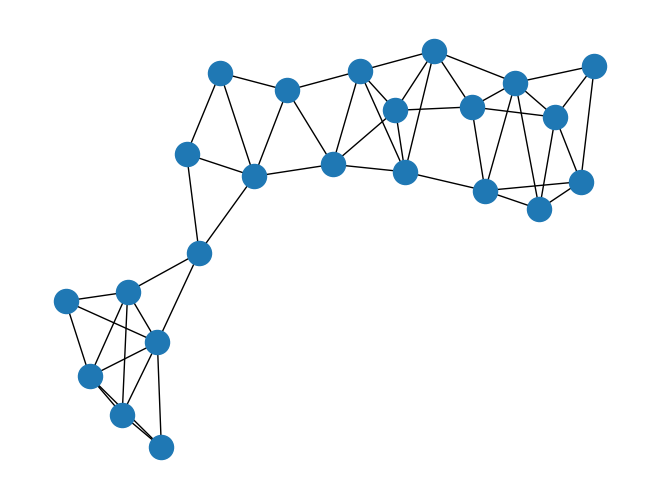

In [20]:
import networkx as nx
G = nx.from_numpy_array(ID_dataset[1].adj_mat)
nx.draw_kamada_kawai(G)

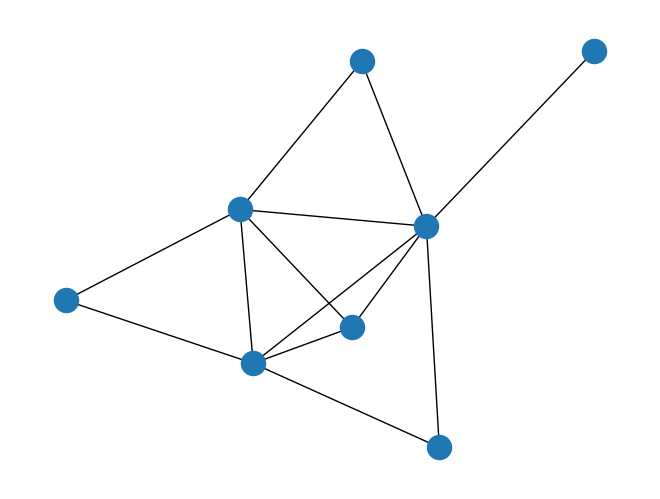

In [52]:
H = nx.Graph()
H.add_edge(1, 2)
H.add_edge(2, 3)
H.add_edge(2, 4)
H.add_edge(2, 5)
H.add_edge(2, 6)
H.add_edge(2, 7)
H.add_edge(3, 4)
H.add_edge(4, 5)
H.add_edge(4, 7)
H.add_edge(4, 8)
H.add_edge(5, 7)
H.add_edge(6, 7)
H.add_edge(7, 8)
nx.draw(H)

In [66]:
x = get_WL_embedding(ID_dataset[0],3)
x[0].keys()

dict_keys(['556d60b01de21111dc0b294d8f8f410e', '4cce99b5d7581a86a31523f2e45a10a7', '1cbf2cd0ea08083f40433ecedd314eb5', 'b99285f9913c31d34191ac87567004d4', '9800e3e814ea4f0ce3b84fac07e3fe18', 'da99e193eea0563d83a09c11d29a5988', '9d37465f647417e86d205012d4f52a59', '7e27c6123e71a222e9adbd653bf437d1', '18bb76d33e5c92198d5fec0543e6253a', '10723a43568e052809fb1ce8a06785ad', 'e14fdb5773794c23c8df9137bbd28978', 'fb77d04e0a808aeace00a1b6f97700c9', '75e9cec589583a081b24f47910a84c60', '52ecaf59f10c3777de50381830d87951', '9b9360d9a07e9373a5ec29889ed3209a', 'a8a3a4379a5272aa8ce5a0a76a36865b', '312606b06301b9b835b2911d277bfcb8', '12744f96c963287e3dda35f31c3d7e13', 'febeb70859c568dbcdb2ad131fb3f651', 'b45bc361482ba6eb13fa3ae067473def', '10f8eb4f4d828f20be7fe944f22b262a', 'bbcd3415100ed49a164e1c7c8c9a092a', 'f44bb81d901a5a3b2eb393e4a9dc3ed7', '256f9fc5a529867c138bc9b7fdcb247f', 'ae7ed0b958d821f427af59120bdfad45', '19a4799c25832ab373c0d157bc28e281', 'c6be44d0326da5bd3a772fa8e64f2a02', 'db7fbd0854be8967

In [68]:
embeddings_dict = {}
all_hashes=set()

for graph in ID_dataset:
    embedding = get_WL_embedding(graph, 3)
    embeddings_dict[graph.id] = embedding
    all_hashes.update(embedding[0].keys())


In [72]:
embeddings_dict[0][0]

{'556d60b01de21111dc0b294d8f8f410e': 2,
 '4cce99b5d7581a86a31523f2e45a10a7': 1,
 '1cbf2cd0ea08083f40433ecedd314eb5': 1,
 'b99285f9913c31d34191ac87567004d4': 1,
 '9800e3e814ea4f0ce3b84fac07e3fe18': 2,
 'da99e193eea0563d83a09c11d29a5988': 1,
 '9d37465f647417e86d205012d4f52a59': 2,
 '7e27c6123e71a222e9adbd653bf437d1': 1,
 '18bb76d33e5c92198d5fec0543e6253a': 1,
 '10723a43568e052809fb1ce8a06785ad': 1,
 'e14fdb5773794c23c8df9137bbd28978': 2,
 'fb77d04e0a808aeace00a1b6f97700c9': 1,
 '75e9cec589583a081b24f47910a84c60': 1,
 '52ecaf59f10c3777de50381830d87951': 1,
 '9b9360d9a07e9373a5ec29889ed3209a': 1,
 'a8a3a4379a5272aa8ce5a0a76a36865b': 1,
 '312606b06301b9b835b2911d277bfcb8': 1,
 '12744f96c963287e3dda35f31c3d7e13': 2,
 'febeb70859c568dbcdb2ad131fb3f651': 1,
 'b45bc361482ba6eb13fa3ae067473def': 1,
 '10f8eb4f4d828f20be7fe944f22b262a': 1,
 'bbcd3415100ed49a164e1c7c8c9a092a': 2,
 'f44bb81d901a5a3b2eb393e4a9dc3ed7': 1,
 '256f9fc5a529867c138bc9b7fdcb247f': 1,
 'ae7ed0b958d821f427af59120bdfad45': 2,


In [73]:
empty_vector = {_hash: 0 for _hash in all_hashes}
for graph in ID_dataset:
    this_vector = {k:v for k, v in empty_vector.items()}
    for key, value in embeddings_dict[graph.id][0].items():
        this_vector[key] += value
    embeddings_dict[graph.id] = (this_vector, empty_vector)


In [22]:
# embeddings_list = np.array(list(embed[0] for embed in embeddings_dict.keys()))

IndexError: invalid index to scalar variable.

In [74]:
Embedding_dataset = EmbeddingAddingDataset(ID_dataset, embeddings_dict)

In [75]:
type(Embedding_dataset[1].embedding[0])

dict

In [76]:
Embedding_dataset[250]['embedding']

({'e38eba9f24a0d127dee71254cdd9a08c': 0,
  '26b4ea520dc4cd06c4b67be6ca1d3c72': 0,
  '9e4addeea08aa07af32886bd7f541744': 0,
  '89d48ab960d4642a5571c6ba7568e0c6': 0,
  'ae13dd3bb801d8c7b60ac03c132970eb': 0,
  '49812dbcd88d4222d0e8e81133a2165f': 0,
  '1df2ec514b46c871c9b3cae4ed662c58': 0,
  'cb3f624e2c0f4a1037cd73c32ef0f054': 0,
  'e7fc31bdd84e0c0a471761ae2db0568f': 0,
  '4e134d8eb1f78c4c41d58e0f8eade79d': 0,
  'f0729a09e0f72acbc913bace60855a13': 0,
  'e45fb59bb27908cd2c9fb7d5bd0888d8': 0,
  '95ffa175df092462a59cfc02565e2223': 0,
  '40e151a234154408f4e3868cc37bffd4': 0,
  '0deabff9a032254ab9ebb5ba5376bc17': 0,
  'a4789507e72bccf242cdca4d7b5867e9': 0,
  'cb86f1a026276d7bb957682e1a8ca2a1': 0,
  '3056716682a0802138a44a3d3725e41b': 0,
  'c7028d17aa2d86e349d029a64bf0231d': 0,
  '96b277866fc2bcac97bc688e800d4fdc': 0,
  '5b305e4ad076447f48ea4ad0696b0f68': 0,
  'f1bebdf184ac95e34a0d468cf5bdb5d5': 0,
  '194b9ee6d69fa3796c2f0292fe32b21e': 0,
  'e3719d3c22509b098d0c14e928182823': 0,
  'a74681d1b09a4

In [77]:
all_hashes, all_classes, mean_vector = get_mean_vectors(Embedding_dataset)


In [78]:
all_classes

{0, 1, 2, 3, 4, 5, 'all'}

In [79]:
cos_sims = {}
class_cos_sims = {_class: [] for _class in all_classes}
for graph in Embedding_dataset:
    cos_sims[graph.id] = get_cos_sim(graph, all_hashes, all_classes, mean_vector)
    class_cos_sims[graph.y.item()].append(cos_sims[graph.id]['class'])
    class_cos_sims['all'].append(cos_sims[graph.id]['all'])


In [42]:
class_cos_sims[0][:10]

[0.36763784537491856,
 0.36663133196303416,
 0.2972706318448856,
 0.2482777490345621,
 0.15593016962915138,
 0.2201754652885534,
 0.3358227412281826,
 0.17347679257241425,
 0.3316100114612869,
 0.17514967312274224]

In [80]:
all_z_scores = {}

for graph in Embedding_dataset:
    all_z_scores[graph.id] = calc_z_scores(graph, cos_sims, class_cos_sims)

In [81]:
# Create the final transform and dataset
Final_dataset = FinalAddingDataset(Embedding_dataset, cos_sims, all_z_scores)

In [82]:
Final_dataset[599]

Data(
  edge_index=[2, 156],
  x=[48, 3],
  y=[1],
  id=599,
  num_edges=156,
  adj_mat=[48, 48],
  embedding=[2],
  cos_sim={
    all=0.05369805379876428,
    class=0.0852943834008729,
  },
  z_score={
    all=0.4222855780221584,
    class=0.7184624161130583,
  }
)

In [84]:
len(Final_dataset[100]['embedding'][0].values())

27816

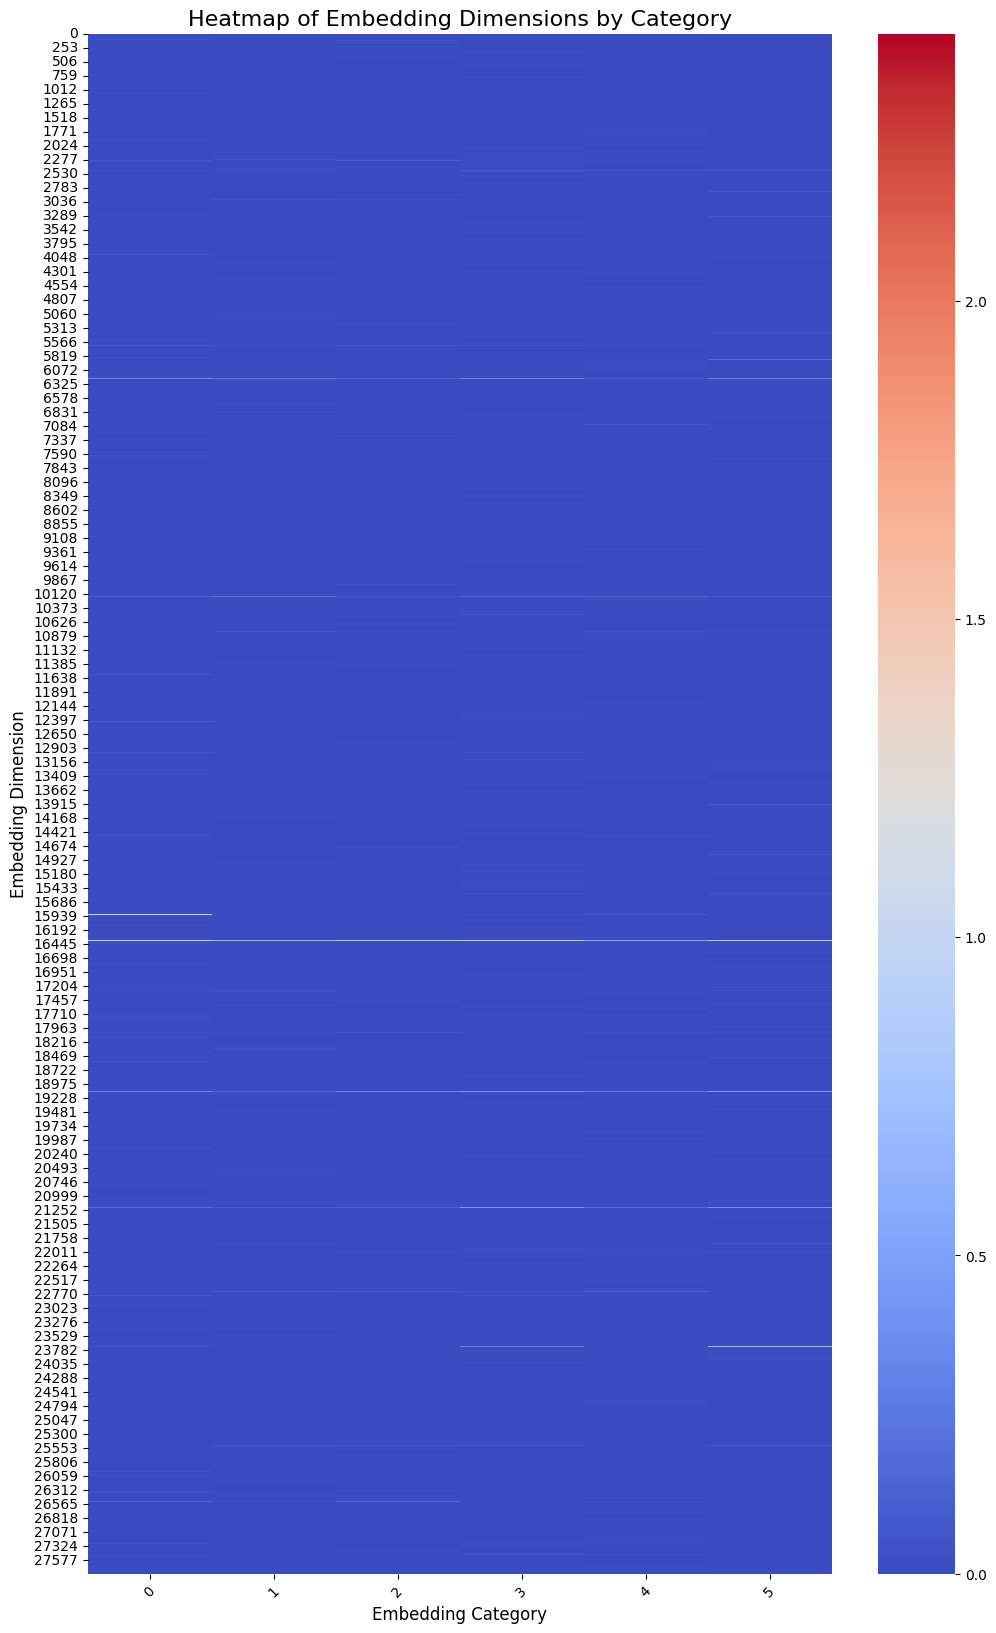

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming Final_dataset is a list or dictionary containing your data
# Extract embeddings and labels for visualization

# Step 1: Extract embeddings and labels
embeddings = []
labels = []

for data in Final_dataset:
    embedding = np.array(list(data['embedding'][0].values()))  # Convert embedding dict to numpy array
    label = int(data['y'])  # Extract the class label (assuming it's stored as int)
    
    embeddings.append(embedding)
    labels.append(label)

# Convert to numpy arrays
X = np.array(embeddings)  # X has shape (600, 27816) - 600 embeddings with 27816 dimensions
y = np.array(labels)  # y has shape (600,) - the labels for each embedding

# Step 2: Calculate the mean of each embedding dimension for each category
unique_labels = np.unique(y)
category_means = []

# For each category, calculate the mean of each embedding dimension
for label in unique_labels:
    category_embeddings = X[y == label]  # Select embeddings that belong to this category
    category_mean = np.mean(category_embeddings, axis=0)  # Mean across embeddings in this category
    category_means.append(category_mean)

# Convert category means to a DataFrame for easier plotting
df_category_means = pd.DataFrame(category_means, index=unique_labels).T

# Step 3: Plot heatmap of the prevalence of each dimension across categories


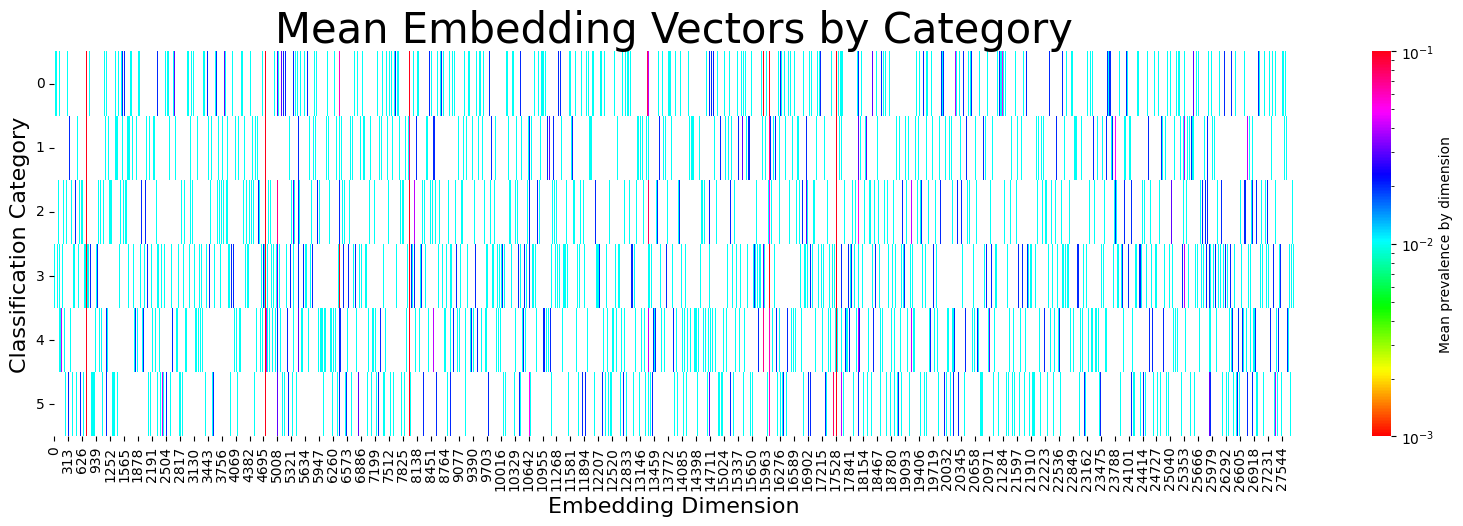

In [203]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(20, 5))
# LogNorm is used for logarithmic color scaling
sns.heatmap(df_category_means.T, cmap='hsv', norm=LogNorm(vmin=1e-3, vmax=1e-1), annot=False, cbar=True, cbar_kws={"label": "Mean prevalence by dimension"})
plt.title("Mean Embedding Vectors by Category", fontsize=30)
plt.xlabel("Embedding Dimension", fontsize=16)
plt.ylabel("Classification Category", fontsize=16)
plt.yticks(rotation=0)
plt.show()

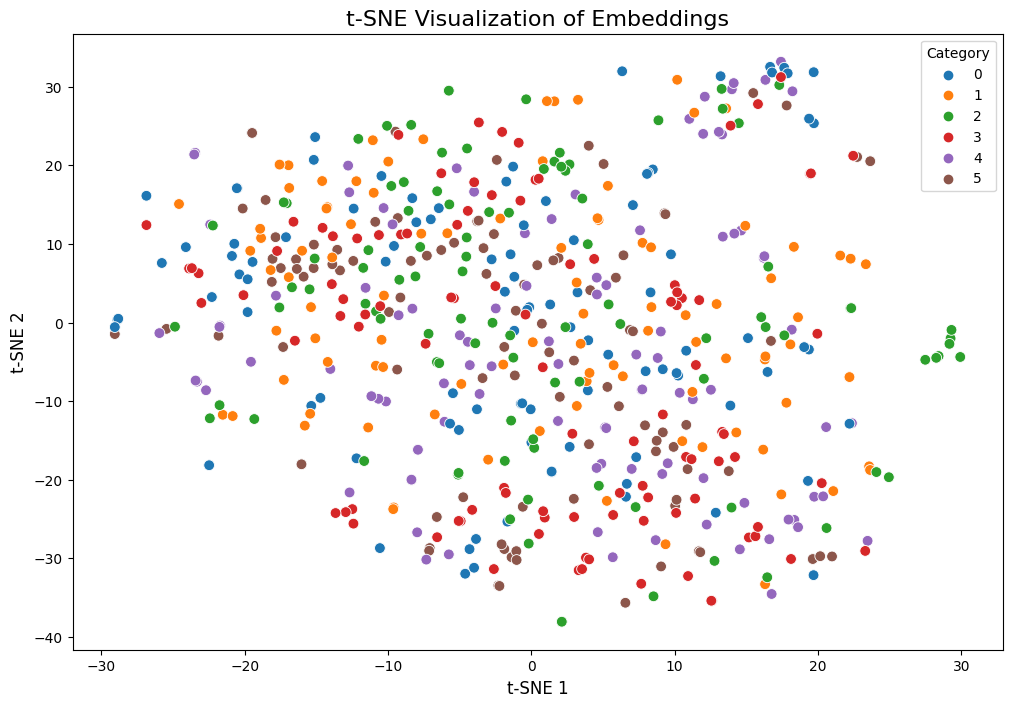

In [204]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Extract embeddings and labels
# This will use the 'embeddings' and 'labels' you already have in your dataset
X = np.array(embeddings)  # X has shape (600, 27816)
y = np.array(labels)  # Labels for each embedding

# Step 2: Apply t-SNE to reduce dimensions
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000, metric='cosine')
X_tsne = tsne.fit_transform(X)

# Step 3: Create a DataFrame with the results
df_tsne = pd.DataFrame(X_tsne, columns=['t-SNE 1', 't-SNE 2'])
df_tsne['label'] = y

# Step 4: Plot the t-SNE results using seaborn
plt.figure(figsize=(12, 8))
sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue='label', palette='tab10', data=df_tsne, s=60)
plt.title("t-SNE Visualization of Embeddings", fontsize=16)
plt.xlabel("t-SNE 1", fontsize=12)
plt.ylabel("t-SNE 2", fontsize=12)
plt.legend(title="Category", loc='best')
plt.show()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Assuming embeddings are already extracted in `X` (shape: 600 embeddings, 27816 dimensions)
# # We'll calculate the correlation matrix across all embedding dimensions

# # Step 1: Convert embeddings to DataFrame for easier manipulation
# df_embeddings = pd.DataFrame(X)  # X has shape (600, 27816), where each column is a dimension

# # Step 2: Calculate the correlation matrix
# corr_matrix = df_embeddings.corr()

# # Step 3: Plot the correlation matrix using seaborn heatmap
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
# plt.title("Correlation Matrix of Embedding Dimensions", fontsize=16)
# plt.xlabel("Embedding Dimension", fontsize=12)
# plt.ylabel("Embedding Dimension", fontsize=12)
# plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming `Final_dataset` contains distribution scores for each embedding

# Step 1: Extract distribution scores and labels
distribution_scores = []
labels = []

for data in Final_dataset:
    score = data['z_score']['class']  # Assuming 'z_score' stores the distribution score for each embedding
    label = int(data['y'])  # Extract the class label
    
    distribution_scores.append(score)
    labels.append(label)

# Convert to numpy arrays for easier manipulation
distribution_scores = np.array(distribution_scores)
labels = np.array(labels)

# Step 2: Create a DataFrame for easier plotting
df_scores = pd.DataFrame({
    'distribution_score': distribution_scores,
    'label': labels
})

# Step 3: Plot KDE for each category
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_scores, x='distribution_score', hue='label', fill=True, palette='tab10')
plt.title("KDE Plot of Distribution Scores by Category", fontsize=16)
plt.xlabel("Distribution Score", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Category")
plt.show()


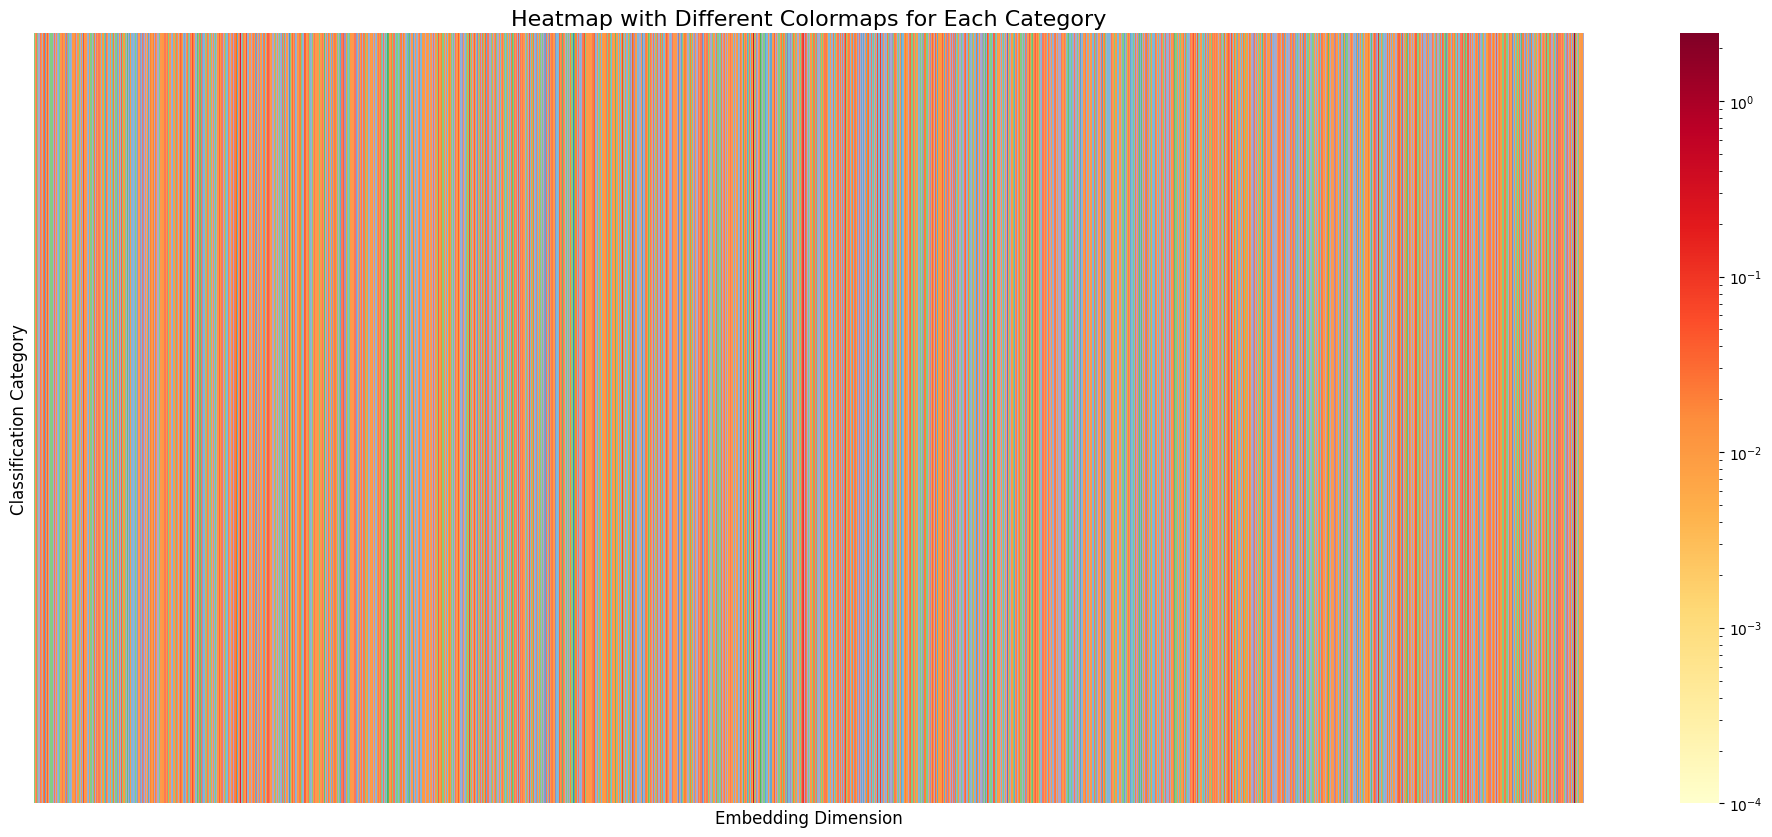

In [109]:
# Step 3: Define a list of colormaps for each category
colormaps = ['Reds', 'Blues', 'Greens', 'Purples', 'Oranges', 'YlOrRd']  # List of colormaps
fig, ax = plt.subplots(figsize=(25, 10))

# Plot each category's heatmap on the same figure, one after the other
num_categories = len(unique_labels)
step = df_category_means.shape[0] // num_categories  # Calculate the step for splitting the x-axis
for i, label in enumerate(unique_labels):
    # Define the range of columns for this category
    category_range = range(i * step, (i + 1) * step)
    # Select the subset of the DataFrame for this category
    data_subset = df_category_means.iloc[:, [i]]
    # Plot the heatmap for the current category using a different colormap
    sns.heatmap(data_subset.T, cmap=colormaps[i % len(colormaps)], norm=LogNorm(vmin=1e-4, vmax=np.max(df_category_means.values)),
                annot=False, cbar=(i == num_categories - 1), ax=ax,
                yticklabels=False, xticklabels=False, cbar_kws={'orientation': 'vertical'})

# Customize the overall plot
ax.set_title("Heatmap with Different Colormaps for Each Category", fontsize=16)
ax.set_xlabel("Embedding Dimension", fontsize=12)
ax.set_ylabel("Classification Category", fontsize=12)
plt.xticks(rotation=45)
plt.show()

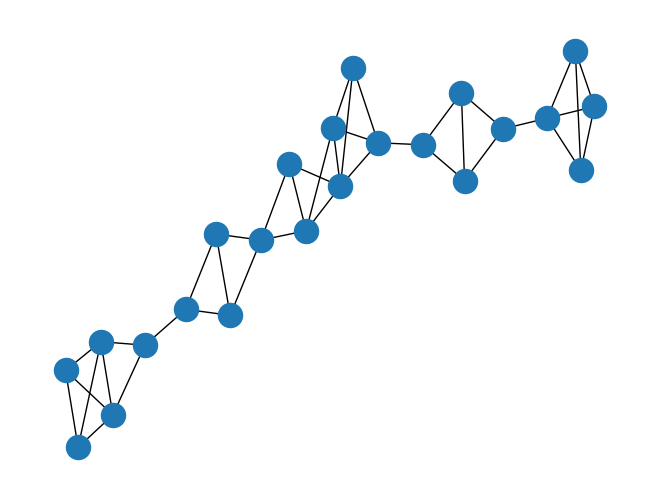

In [129]:
Final_dataset[8]
high_graph = nx.from_numpy_array(Final_dataset[8].adj_mat)
nx.draw_kamada_kawai(high_graph)

In [119]:
low_embedding = Final_dataset[2].embedding[0]
high_embedding = Final_dataset[8].embedding[0]

In [124]:
set(low_embedding.keys()) & set(high_embedding.keys())

{'ae5ac1bd1826907525a81206cb821cd4',
 'cdcab697efcb39eb787a4aae93f2dde5',
 'e0a3365d1f3b5aff7d5178b3e969865b'}

In [123]:
sorted(high_embedding.keys())

['0b7f2fb63565d1c89a6eca7953b4c430',
 '0b9fe300289ac5e151c2360a400e17fc',
 '0fa32135753799005d636a3df46b0b3d',
 '12325346d466473752035910a24b3269',
 '1fcc9c604a7b4dbcda3e4d15001345cf',
 '1fd82ad6d462bf1a650af2d522192438',
 '2b7261f1ae1aa76c85e3e036f6be4931',
 '2ca521069231d777dbb74d121c71946f',
 '2e29389fe1de80ffae66a1bcc735b53c',
 '34a28d4d50521dc609cdf69d360d8eae',
 '4db532d4b8f8527f49062bf7703dd00b',
 '4ff8ef46aac95a2a6d417a1488e7f509',
 '5ae0793a45e9f3ed6a2e46c7e082217e',
 '5bdcffb2cd7d098a564043ab9f3fb2a8',
 '63d5d213c0608f3d8ec5617d1c9ea5c1',
 '727c986009c8eb452a8b475c3434c05b',
 '75dc1613862a70d645b1920afa1379b5',
 '7bec2690ce1adae78aca6d6d2bb76e9d',
 '89d23d9cdcf0f5b007f2f3f3f1e332a3',
 '8a50e8693c465f86085d8dd57f7d4261',
 '90b40c386cdda1ba9a10bf357c0ee3ef',
 '9550d5cc2b323279e5d8c704f037dc15',
 '9c0caa91ef31f1dd338bdc0cd65dd12c',
 'aca00fc643c57ccd885b7bc3e7d804e5',
 'ae5ac1bd1826907525a81206cb821cd4',
 'af9ba231e75023723f3dfbf4b5b4f8a5',
 'b1ae6e0afb59979c88f6eb36a122f3ff',
 

In [113]:
len(high_embedding)

43

In [115]:
len(low_embedding and high_embedding)

43

In [111]:
len(low_embedding.symmetric_difference(high_embedding))

89

In [92]:
common_embeddings = set(low_embedding.keys()) and set(high_embedding.keys())
both_embeddings = set(low_embedding.keys()) or set(high_embedding.keys())

In [106]:
set(low_embedding.keys()).symmetric_difference(set(high_embedding.keys()))

AttributeError: 'list' object has no attribute 'keys'

In [93]:
both_embeddings

{'091c187b4d7eafef22a8a5e6d6d93ded',
 '0d5b504ca8898a80616543dcfd00c822',
 '10c9df538fcc69d62fb9e92ea22c4de1',
 '12744f96c963287e3dda35f31c3d7e13',
 '15a39ef5e7449376401e15ccbf1e01a1',
 '1ae00d3b4018cec91e94fa7af8d053d6',
 '1bc08f3b526a556bac765d86afb585a1',
 '22c07a85419f142d7dbb614db698a6c1',
 '2a0d38f662ffcd20c416300d783c3e30',
 '2a4c7207b57af5d3d4df91e8e37ec88c',
 '2a67c852baf4fb9dc5ea6ac536c3387e',
 '2d349d8809b53ec9a8cda6e71f351152',
 '37645dc342bf9153ce4489eea34c9607',
 '49a204c15150fee66e7cca85ed69e486',
 '4be58e264d304b054d22acb1da65caa2',
 '506cbdbca2db6d703e4cf7d4c41bccff',
 '56aef942c68754b1bd2e46fe01dbf308',
 '58e6dbe53142990b3809d2048f039881',
 '604a6cc48eb2a11e6502577990e8ca97',
 '68ffa5906cc22a8795e6bc65fdb67ab2',
 '6b641c27b3f40c9821415b5993e93b35',
 '6d1495af64b5f64c517defa65df1044a',
 '6ed10a967e57269f2f594f98a817f3fd',
 '74a88565bd3e934de896cbfcf23926fa',
 '764e4d215278c722bd0b375ffee43fd2',
 '78bb636c808d78428386abe3a11351ab',
 '7c98ca8f688f51c5e3fdd2f8848f5aba',
 

In [104]:
set(both_embeddings - common_embeddings)

{'091c187b4d7eafef22a8a5e6d6d93ded',
 '0d5b504ca8898a80616543dcfd00c822',
 '10c9df538fcc69d62fb9e92ea22c4de1',
 '12744f96c963287e3dda35f31c3d7e13',
 '15a39ef5e7449376401e15ccbf1e01a1',
 '1ae00d3b4018cec91e94fa7af8d053d6',
 '1bc08f3b526a556bac765d86afb585a1',
 '22c07a85419f142d7dbb614db698a6c1',
 '2a0d38f662ffcd20c416300d783c3e30',
 '2a4c7207b57af5d3d4df91e8e37ec88c',
 '2a67c852baf4fb9dc5ea6ac536c3387e',
 '2d349d8809b53ec9a8cda6e71f351152',
 '37645dc342bf9153ce4489eea34c9607',
 '49a204c15150fee66e7cca85ed69e486',
 '4be58e264d304b054d22acb1da65caa2',
 '506cbdbca2db6d703e4cf7d4c41bccff',
 '56aef942c68754b1bd2e46fe01dbf308',
 '58e6dbe53142990b3809d2048f039881',
 '604a6cc48eb2a11e6502577990e8ca97',
 '68ffa5906cc22a8795e6bc65fdb67ab2',
 '6b641c27b3f40c9821415b5993e93b35',
 '6d1495af64b5f64c517defa65df1044a',
 '6ed10a967e57269f2f594f98a817f3fd',
 '74a88565bd3e934de896cbfcf23926fa',
 '764e4d215278c722bd0b375ffee43fd2',
 '78bb636c808d78428386abe3a11351ab',
 '7c98ca8f688f51c5e3fdd2f8848f5aba',
 

In [ ]:
num_node_dict = {_cls: {graph.id: graph.num_nodes for graph in Final_dataset if graph.y.item() == _cls or _cls == 'all'} for _cls in all_classes}
num_node_mean_dict = {_cls: sum(num_node_dict[_cls].values())/len(num_node_dict[_cls].values()) for _cls in all_classes}
node_diff_dict = {_cls: {graph.id: graph.num_nodes - num_node_mean_dict[_cls] for graph in Final_dataset if graph.y.item() == _cls or _cls == 'all'} for _cls in all_classes}
pos_diff_dict = {_cls: {} for _cls in all_classes}
neg_diff_dict = {_cls: {} for _cls in all_classes}
for _cls, _dict in node_diff_dict.items():
    for idx, node_diff in _dict.items():
        if node_diff > 0:
            pos_diff_dict[_cls][idx] = node_diff
        else:
            pos_diff_dict[_cls][idx] = node_diff
pos_num_node_dict = {_cls: len(pos_diff_dict[_cls]) for _cls in all_classes}
neg_num_node_dict = {_cls: len(neg_diff_dict[_cls]) for _cls in all_classes}
percentile_dict = {graph.id: {'all': 0, 'class': 0} for graph in Final_dataset}
for _cls, _dict in pos_diff_dict.items():
    for i, (idx, val) in enumerate(sorted(_dict.items(), key = lambda x: x[1])):
        if _cls != 'all':
            percentile_dict[idx]['class'] = i/pos_num_node_dict[_cls]
        else:
            percentile_dict[idx]['all'] = i/pos_num_node_dict[_cls]
for _cls, _dict in neg_diff_dict.items():
    for i, (idx, val) in enumerate(sorted(_dict.items(), key = lambda x: x[1], reverse=True)):
        if _cls != 'all':
            percentile_dict[idx]['class'] = i/neg_num_node_dict[_cls]
        else:
            percentile_dict[idx]['all'] = i/neg_num_node_dict[_cls]
    

                       

In [ ]:
num_node_percentile_dict = percentile_dict
for x in range(20):
    print(num_node_percentile_dict[x])

In [ ]:
cos_sim_dict = {_cls: {} for _cls in all_classes}
for graph in Final_dataset:
    cos_sim_dict[graph.y.item()][graph.id] = graph.cos_sim['class']
    cos_sim_dict['all'][graph.id] = graph.cos_sim['all']
            

cat_len_dict = {_cls: len(cos_sim_dict[_cls].values()) for _cls in all_classes}
cos_sim_percentile_dict = {graph.id: {'all': 0, 'class': 0} for graph in Final_dataset}


for _cls, _dict in cos_sim_dict.items():
    for i, (idx, val) in enumerate(sorted(_dict.items(), key = lambda x: x[1])):
        if _cls != 'all':
            cos_sim_percentile_dict[idx]['class'] = i/cat_len_dict[_cls]
        else:
            cos_sim_percentile_dict[idx]['all'] = i/cat_len_dict[_cls]


In [ ]:
for x in range(10):
    print(cos_sim_percentile_dict[x])

In [ ]:
percentiles = [x for x in range(35, 91, 5)]
cats = ['class', 'all']
metrics = ['random', 'graph_order', 'cos_sim']
train_indices_dict = {cat: {metric: {percentile: [] for percentile in percentiles} for metric in metrics} for cat in cats}
for percentile in percentiles:
    for idx, cat_pairs in cos_sim_percentile_dict.items():
        for cat, val in cat_pairs.items():
            if val < 0.01*percentile:
                train_indices_dict[cat]['cos_sim'][percentile].append(idx)
    for idx, cat_pairs in num_node_percentile_dict.items():
        for cat, val in cat_pairs.items():
            if val < 0.01* percentile:
                train_indices_dict[cat]['graph_order'][percentile].append(idx)
    for _cls, id_pairs in num_node_dict.items():
        for cat in cats:
            size = int(percentile * 0.01 * len(id_pairs))
            train_indices_dict[cat]['random'][percentile] = np.random.choice(list(id_pairs.keys()), size, replace=False)
            
        
        

In [ ]:
import pickle

# Specify the path to the file where you want to save the dataset
file_path = f'/kaggle/working/{DATASET}_train_indices_dict.pkl'

# Saving the dataset
with open(file_path, 'wb') as file:
    pickle.dump(train_indices_dict, file)

print("Dict saved successfully.")

In [ ]:
# import matplotlib.pyplot as plt
# # for x in range(6):
# all_z_scores = [graph.num_nodes for graph in Final_dataset]
# num_node_mean = sum(all_z_scores)/600
# all_z_scores = [x - num_node_mean for x in all_z_scores]
# percentiles = [50, 95, 99]  # Change these values based on your requirements (xx%)
# percentile_values = np.percentile(all_z_scores, percentiles)

# plt.figure(figsize=(10, 6))
# plt.hist(all_z_scores, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
# plt.title('Histogram of Z-Scores with Percentiles')
# plt.xlabel('Z-Score')
# plt.ylabel('Frequency')

# # Add vertical lines for each percentile
# for perc, value in zip(percentiles, percentile_values):
#     plt.axvline(x=value, color='r', linestyle='--', label=f'{perc}th percentile: {value:.2f}')

# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
import pickle

# Specify the path to the file where you want to save the dataset
file_path = f'/kaggle/working/{DATASET}.pt'

# Saving the dataset
with open(file_path, 'wb') as file:
    torch.save(Final_dataset, file)

print("Dataset saved successfully.")

In [ ]:
import os

# Define the directory you want to list
directory_path = '/kaggle/working/'

# List all files and directories in the specified path
contents = os.listdir(directory_path)

print("Contents of '/kaggle/working/':")
for item in contents:
    print(item)